# Get a word cloud with the topics covered in the papers citing ChEMBL paper
Running ollama locally, using lighter Gemma 2 2b

In [254]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests
import json
import ast
import re

ollama_url = "http://127.0.0.1:11434/api/generate"

def clean_llm_json(res):
    match = re.search(r'\{.*\}', res)
    if match:
        result = match.group(0)
    else:
        result = None
    return result

def get_paper_topics(abstract):
    
    prompt = f"""I'm including a scientific paper abstract at the end of the prompt. 
    Find the 5 most important categories for the paper by only using the abstract.
    Return only a raw JSON string that follows the format: {{"categories": ["category1", "category2", "category3", "category4", "category5"]}}"

    Abstract: {abstract}    
    """
    
    payload = {
      "model": "gemma2:2b",
      "prompt": prompt,
      "stream": False
    }
    response = requests.post(ollama_url, data=json.dumps(payload))
    json_string = clean_llm_json(response.json()['response'])
    res = json.loads(json_string)
    return res

- Get all papers citing our paper
- Get the abstracts of each citing paper
- Extract 5 most relevant topics using an LLM with ollama

In [ ]:
pmcid = 30398643 # ChEMBL: towards direct deposition of bioassay data

# get all citing papers from EuropePMC, should paginate instead of taking 1000 items per page...
citations_url = f'https://www.ebi.ac.uk/europepmc/webservices/rest/MED/{pmcid}/citations?format=json&pageSize=1000'
citations_response = requests.get(citations_url)
citations_data = citations_response.json()

topic_counts = {}
for citation in citations_data['citationList']['citation']:
    cit_pmcid = citation['id']
    
    # get paper info from EuropePMC
    paper_url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=EXT_ID:{cit_pmcid}&format=json&resulttype=core"
    response = requests.get(paper_url)
    article = response.json()['resultList']['result'][0]
    abstract = article.get('abstractText')
    try:
        topics = get_paper_topics(abstract)
    except:
        print("error", cit_pmcid)
        continue
    
    for topic in topics['categories']:
        topic = topic.lower()
        if topic in topic_counts:
            topic_counts[topic] += 1
        else:
            topic_counts[topic] = 1

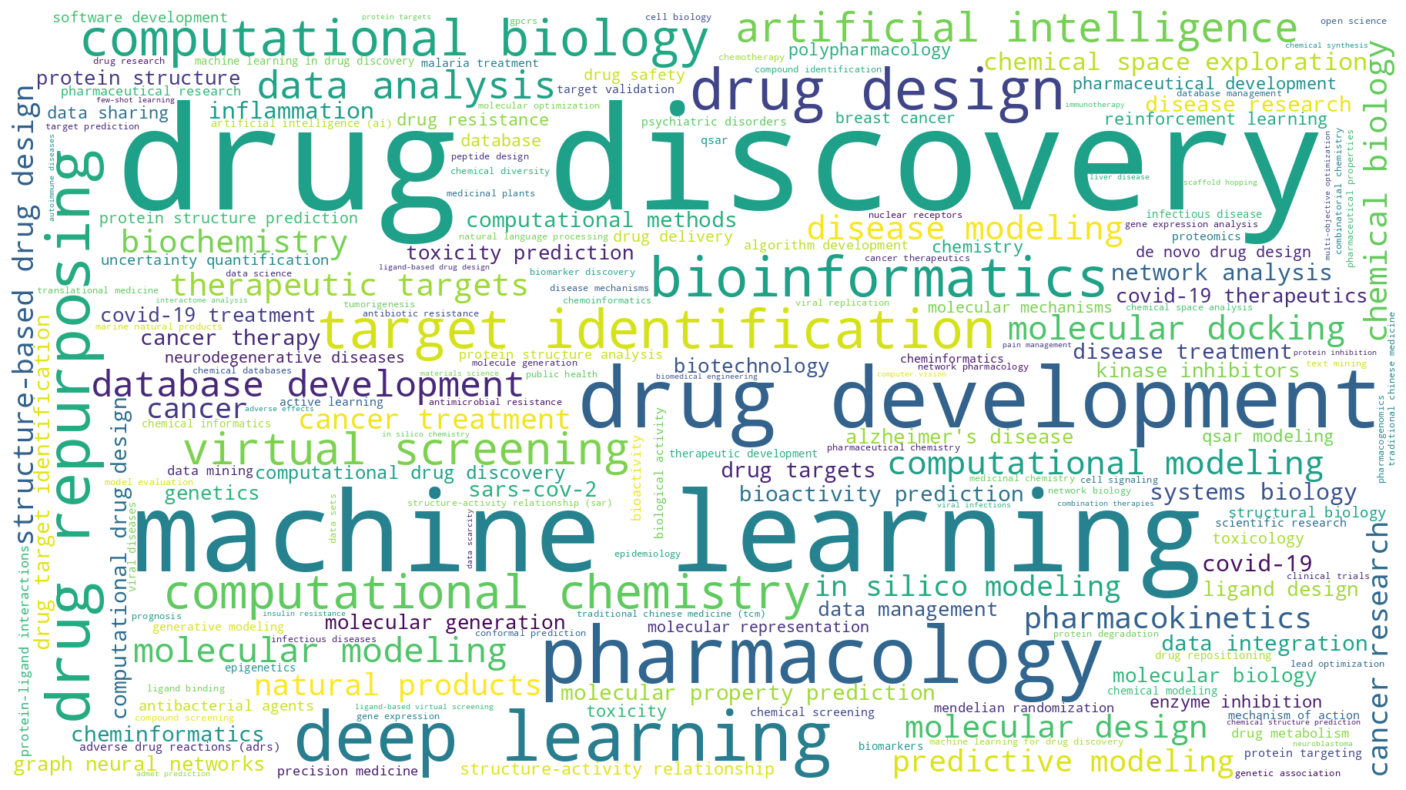

In [267]:
wordcloud = WordCloud(width=1800, height=1000, background_color='white').generate_from_frequencies(topic_counts)
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()